In [1]:
from core import *
from utils import *
from diagnostics import *
from fields import *
from constants import *
from distributions import *

from scipy import constants as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

import cProfile

def plot_traj(history):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = history[i, :, 0]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()

Load IGRF coefficients ...


In [2]:
b_field = t89(0)

In [3]:
from math import floor, ceil

@njit
def discretize_field(b_field, n_x, n_y, n_z, x_lim, y_lim, z_lim):
    b_field_cells = np.zeros((n_x, n_y, n_z, 3))
    
    x_width = (x_lim[1] - x_lim[0]) / n_x
    y_width = (y_lim[1] - y_lim[0]) / n_y
    z_width = (z_lim[1] - z_lim[0]) / n_z

    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_z):
                loc_x = x_lim[0] + x_width * i
                loc_y = y_lim[0] + y_width * j
                loc_z = z_lim[0] + z_width * k

                b_field_cells[i, j, k] = b_field(np.array([loc_x, loc_y, loc_z]))
    
    return b_field_cells

@njit
def call_discretized_field(r, b_field_cells, n_x, n_y, n_z, x_lim, y_lim, z_lim):
    x_width = (x_lim[1] - x_lim[0]) / n_x
    y_width = (y_lim[1] - y_lim[0]) / n_y
    z_width = (z_lim[1] - z_lim[0]) / n_z
    
    x_closest = (r[0] - x_lim[0]) / x_width
    y_closest = (r[1] - y_lim[0]) / y_width
    z_closest = (r[2] - z_lim[0]) / z_width
    
    xn0 = floor(x_closest)
    xn1 = ceil(x_closest)
    yn0 = floor(y_closest)
    yn1 = ceil(y_closest)
    zn0 = floor(z_closest)
    zn1 = ceil(z_closest)
    
    b0 = b_field_cells[xn0, yn0, zn0]
    b1 = b_field_cells[xn1, yn1, zn1]
    
    n1 = np.sqrt( ((xn1 - xn0) * x_width)**2 + ((yn1 - yn0) * y_width)**2 + ((zn1 - zn0) * z_width)**2 )
    n = np.sqrt( ((x_closest - xn0) * x_width)**2 + ((y_closest - yn0) * y_width)**2 + ((z_closest - zn0) * z_width)**2 )
    
    return ((b1 - b0) / n1) * n + b0

In [4]:
nx = 101
ny = 81
nz = 81

x_lim = np.array([-15 * Re, 10 * Re])
y_lim = np.array([-10 * Re, 10 * Re])
z_lim = np.array([-10 * Re, 10 * Re])

b_field_cells = discretize_field(b_field, nx, ny, nz, x_lim, y_lim, z_lim)

@njit
def consolidated(r, t = 0):
    return call_discretized_field(r, b_field_cells, nx, ny, nz, x_lim, y_lim, z_lim)

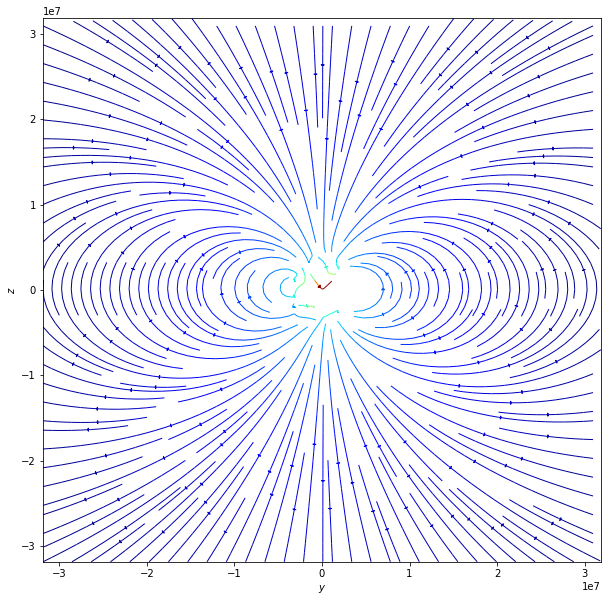

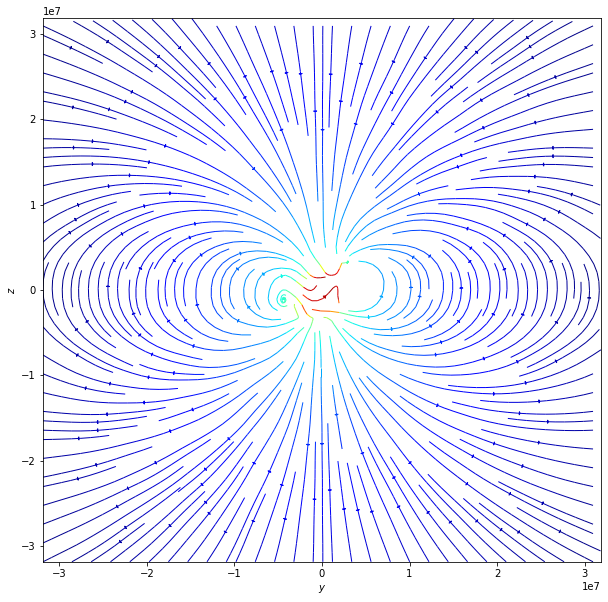

In [5]:
plot_field(b_field, 'x', 50, [-5 * Re, 5 * Re], [-5 * Re, 5 * Re], (10, 10))
plot_field(consolidated, 'x', 50, [-5 * Re, 5 * Re], [-5 * Re, 5 * Re], (10, 10))

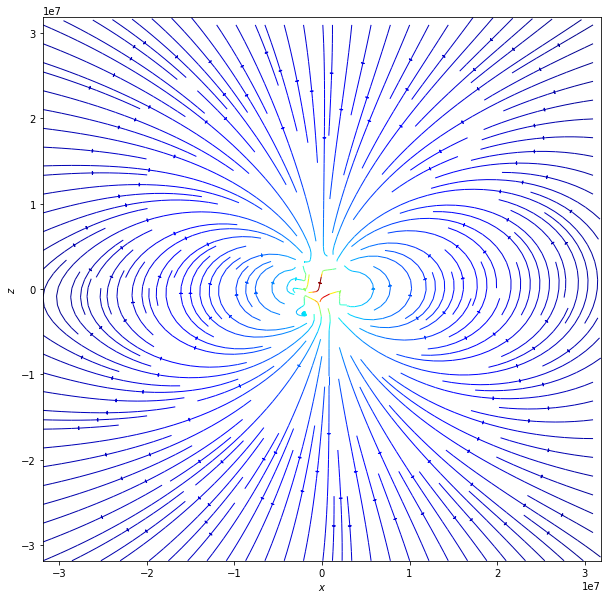

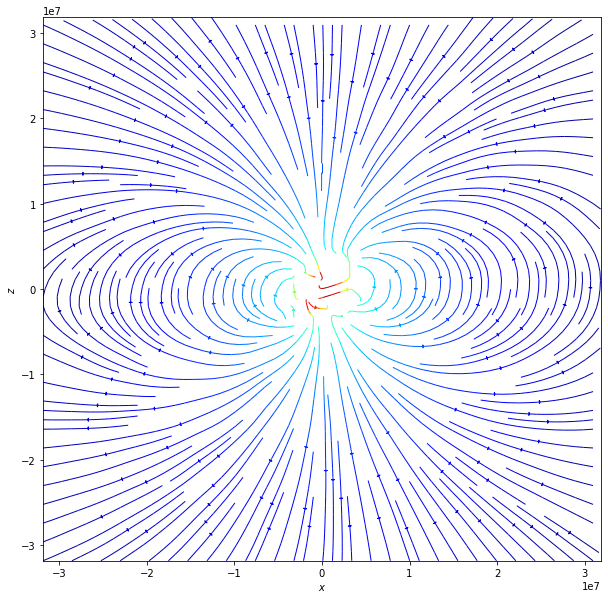

In [6]:
plot_field(b_field, 'y', 50, [-5 * Re, 5 * Re], [-5 * Re, 5 * Re], (10, 10))
plot_field(consolidated, 'y', 50, [-5 * Re, 5 * Re], [-5 * Re, 5 * Re], (10, 10))

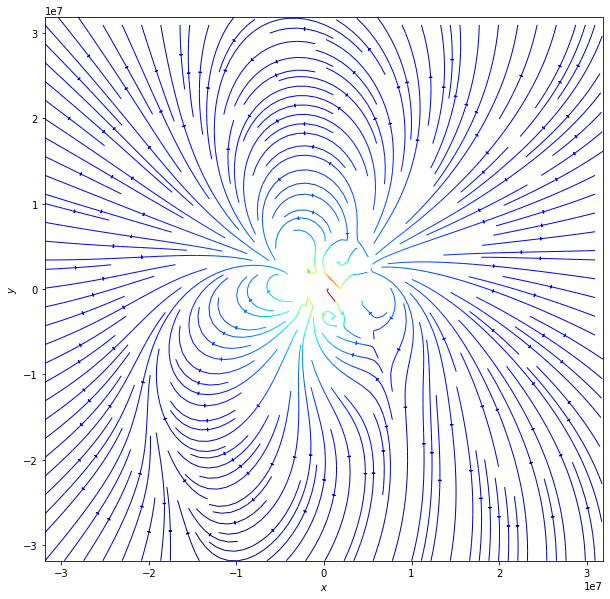

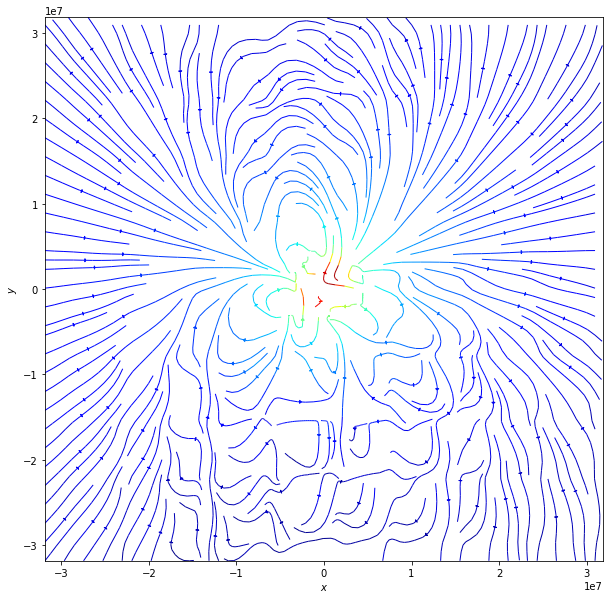

In [7]:
plot_field(b_field, 'z', 50, [-5 * Re, 5 * Re], [-5 * Re, 5 * Re], (10, 10))
plot_field(consolidated, 'z', 50, [-5 * Re, 5 * Re], [-5 * Re, 5 * Re], (10, 10))

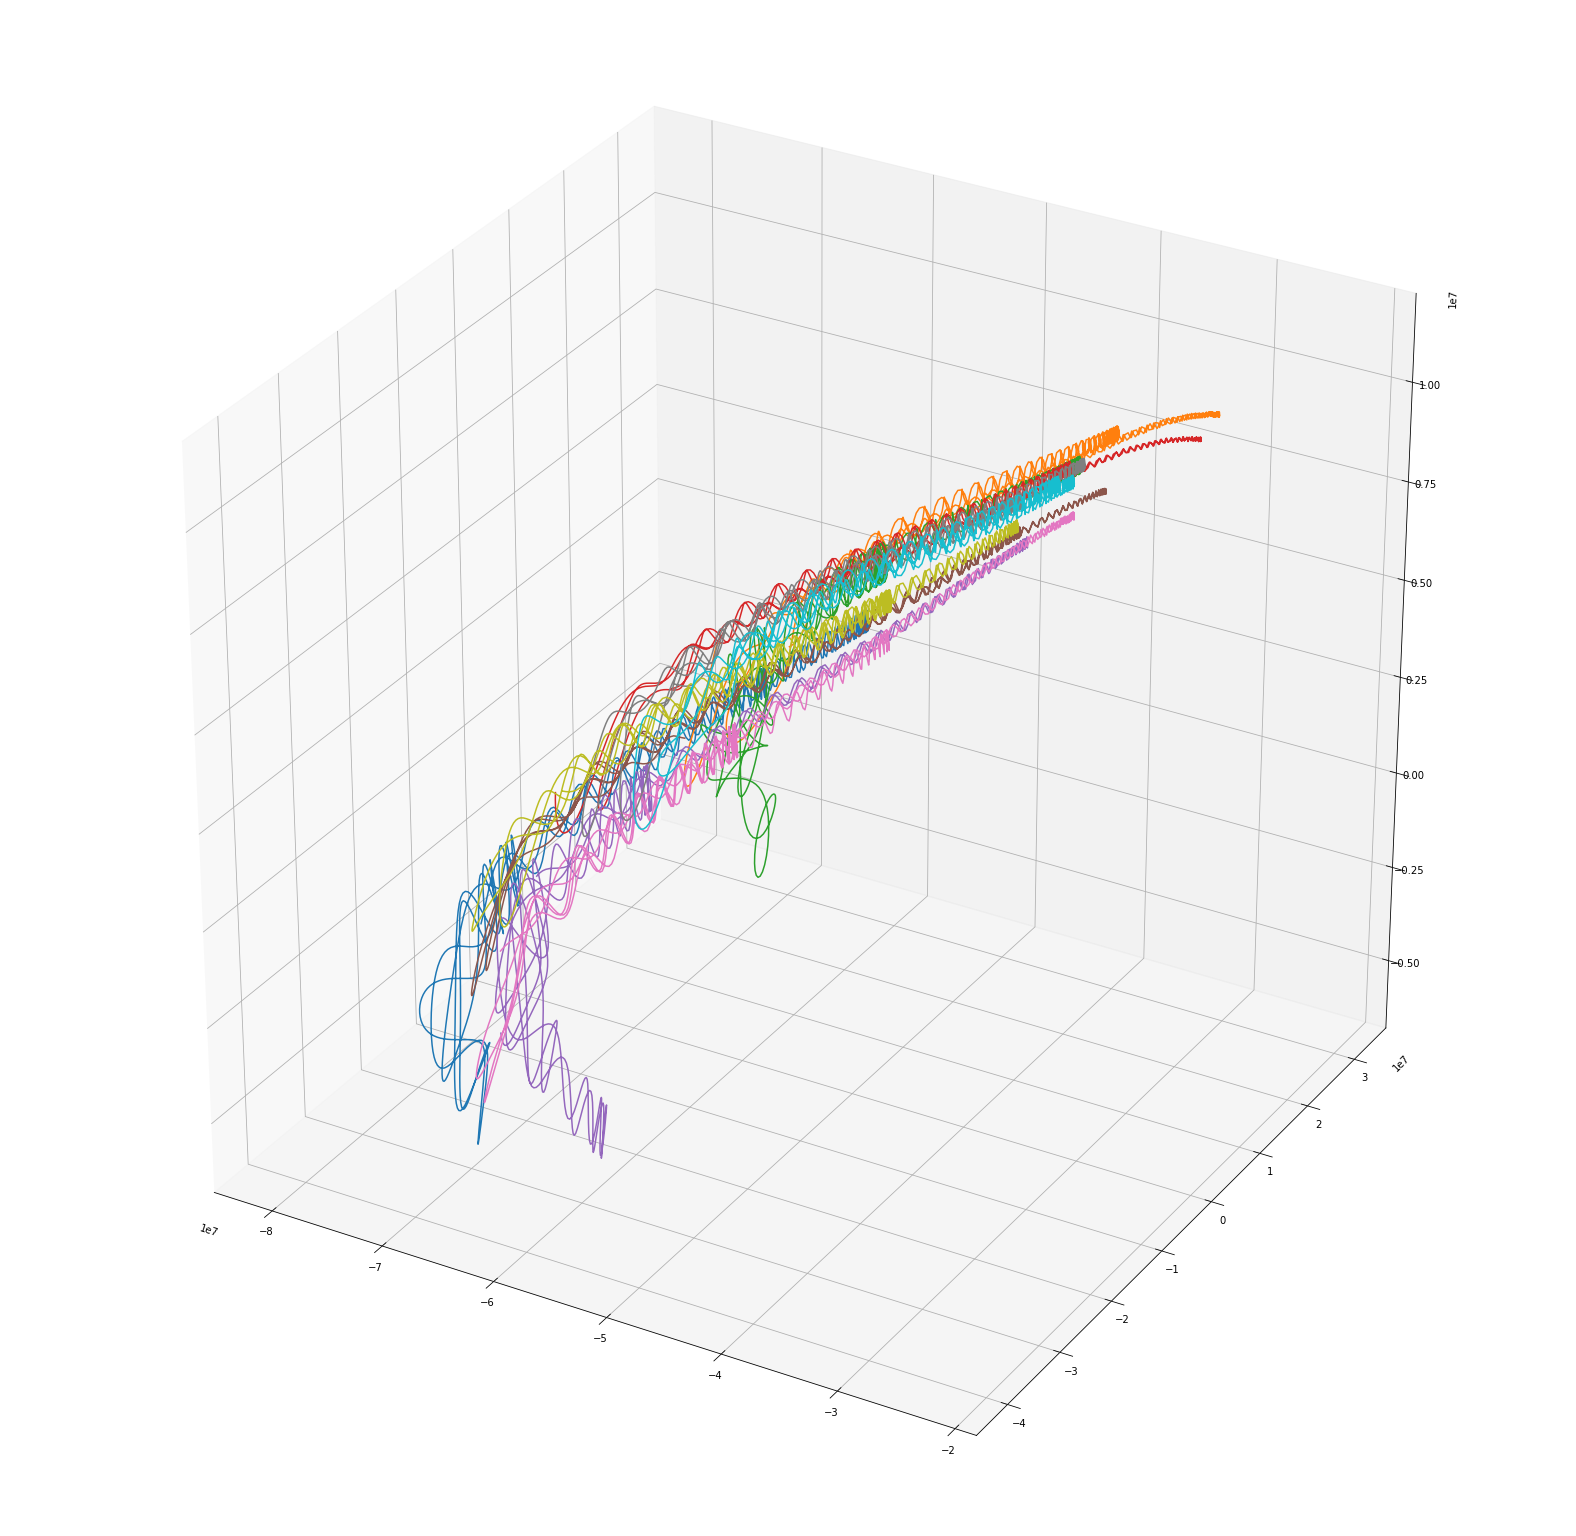

In [8]:
e_field = zero_field()
solve   = solver(relativistic_boris(e_field, b_field))

T      = 1           # Total time (in seconds)
dt     = 1e-3        # Simulation time step
trials = 10          # Number of runs
steps  = int(T / dt) # Number of steps per run

history_orig, intrinsic = populate(trials,
                              steps,
                              e_field,
                              b_field,
                              uniform_partial_ring(11 * Re, 12 * Re, 5 * np.pi / 6, 7 * np.pi / 6),
                              delta(1e7),
                              delta(np.pi / 8),
                              uniform(0, 2 * np.pi)
                             )

history_disc = np.copy(history_orig)
solve(history_orig, intrinsic, dt)
plot_traj(history_orig)

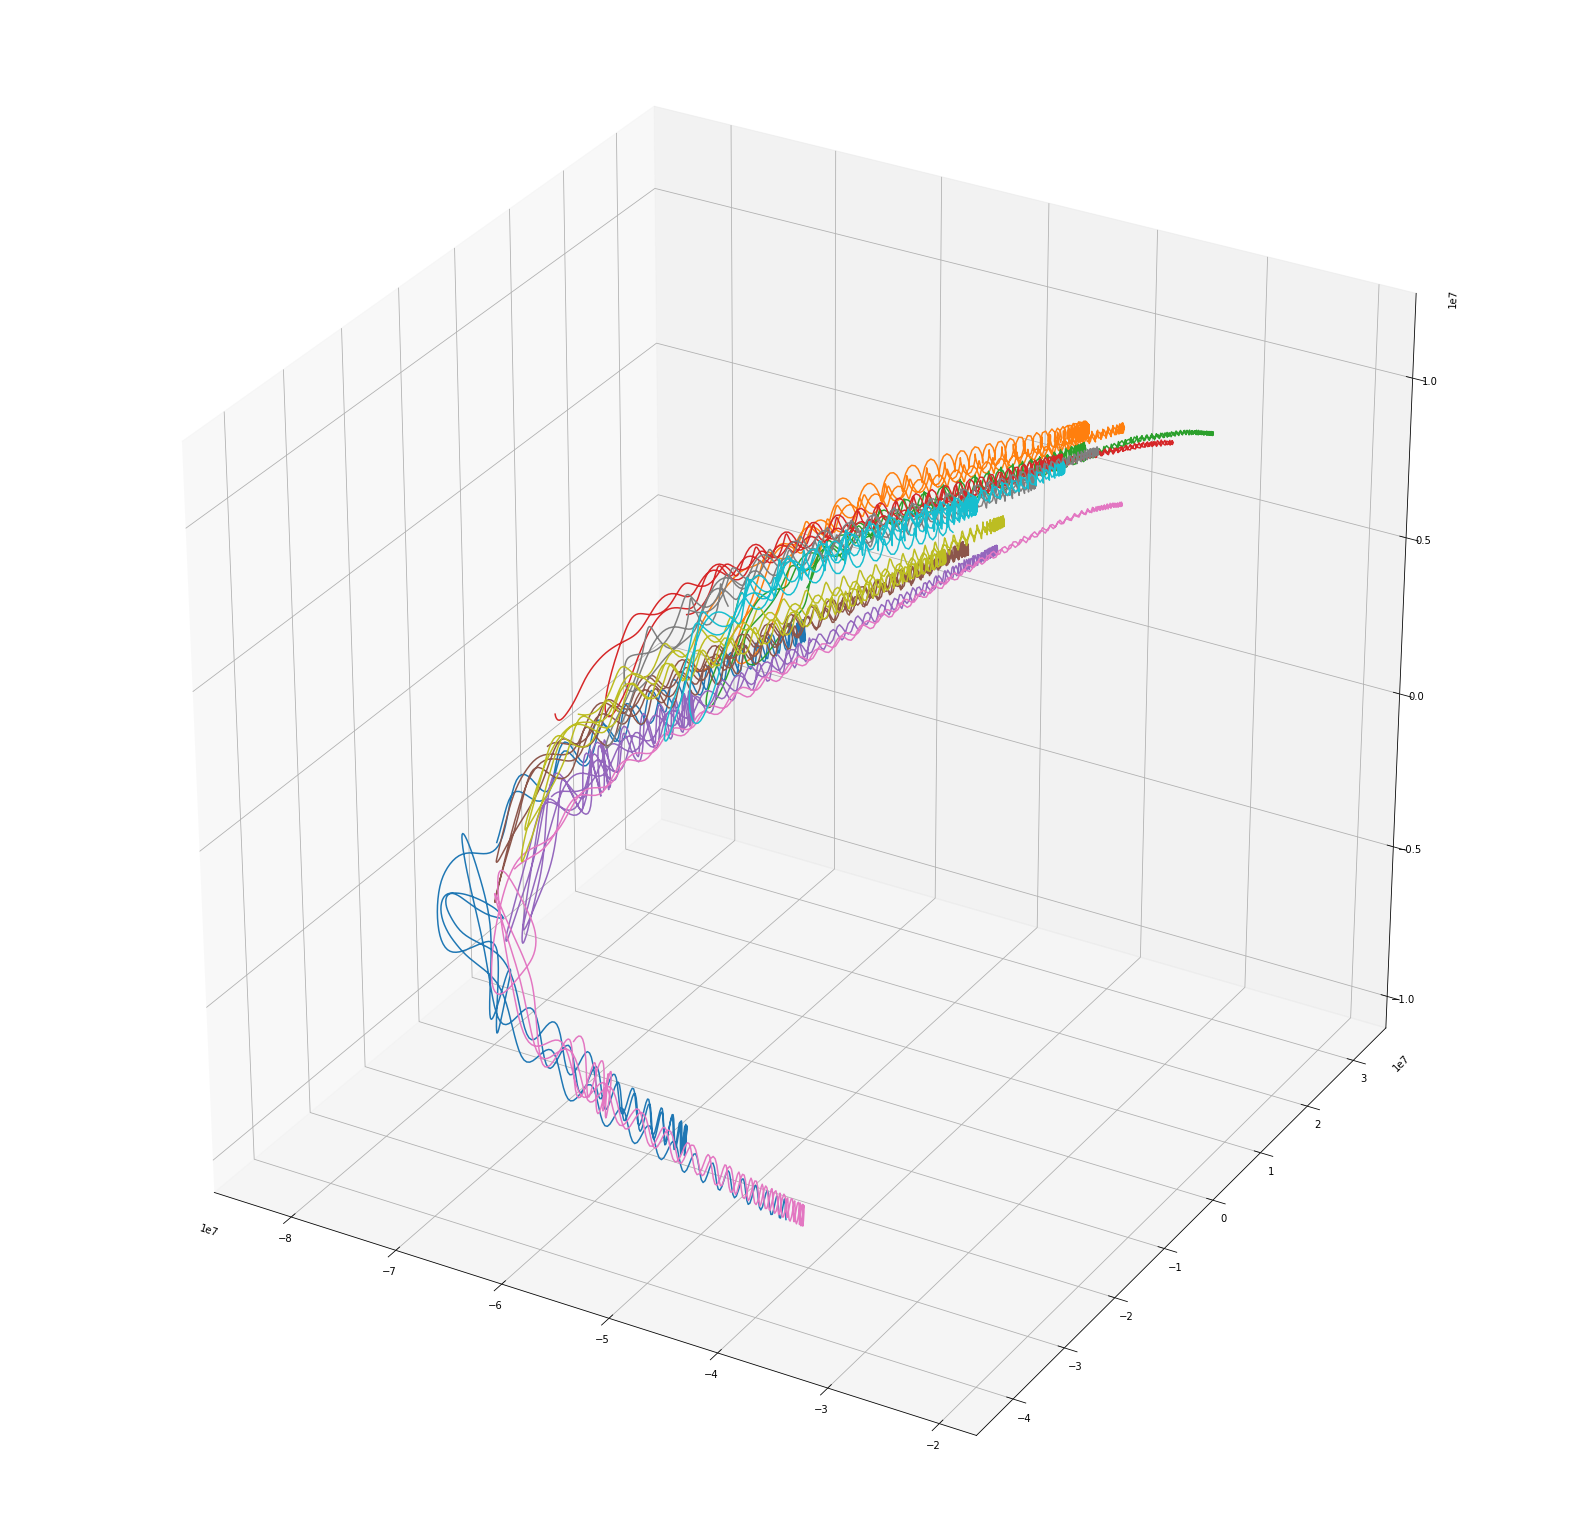

In [9]:
solve = solver(relativistic_boris(e_field, consolidated))
solve(history_disc, intrinsic, dt)
plot_traj(history_disc)